## 1.1 Introduction

**Dataset:** Customer Churn Dataset
<br>**Source:** Kaggle
<br>**Context:** This Dataset contains the financial information of an membership firm.
<br>**Objective:** Objective is to predict risk score of the member so that organization can avert the risk fafctor.


## 1.2 Preprocessing Dataset

### 1.2.1 Importing Libraries

In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

### 1.2.2 Reading Dataset

In [2]:
df = pd.read_parquet(r'../dataset/churn.parquet')
df.head(3)

,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,XW0DQ7H,Village,Platinum Membership,17-08-2017,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,32,F,5K0N3X1,City,Premium Membership,28-08-2017,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,44,F,1F2TCL3,Town,No Membership,11-11-2016,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1


### 1.2.3 Analyze Dataset Structure

#### 1.2.3.1 Rows & Columns

In [3]:
print(f"Dataset contains {df.shape[0]} records and {df.shape[1]} features..!!")

Dataset contains 36992 records and 23 features..!!


#### 1.2.3.2 Removing Duplicates

In [4]:
print(f"Dropping: Duplicate Records\t {df.duplicated().sum()}")
df = df.drop_duplicates()

Dropping: Duplicate Records	 0


#### 1.2.3.3 Features Statistics


In [5]:
target_feature = df['churn_risk_score']

features = ['age', 'gender', 'security_no', 'region_category',
       'membership_category', 'joining_date', 'joined_through_referral',
       'referral_id', 'preferred_offer_types', 'medium_of_operation',
       'internet_option', 'last_visit_time', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback',]

numeric_features = df[features].select_dtypes(include=np.number)
categorical_features = df[features].select_dtypes(exclude=np.number)

In [6]:
# Numeric Features Stats
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36992.0,37.118161,15.867412,10.000000,23.0000,37.000,51.000,64.000000
days_since_last_login,36992.0,-41.915576,228.819900,-999.000000,8.0000,12.000,16.000,26.000000
avg_time_spent,36992.0,243.472334,398.289149,-2814.109110,60.1025,161.765,356.515,3235.578521
avg_transaction_value,36992.0,29271.194003,19444.806226,800.460000,14177.5400,27554.485,40855.110,99914.050000
points_in_wallet,33549.0,686.882199,194.063624,-760.661236,616.1500,697.620,763.950,2069.069761


In [7]:
# Categorical Features Stats
categorical_features.describe().T

,count,unique,top,freq
gender,36992,3,F,18490
security_no,36992,36992,XW0DQ7H,1
region_category,31564,3,Town,14128
membership_category,36992,6,Basic Membership,7724
joining_date,36992,1096,02-06-2015,55
joined_through_referral,36992,3,No,15839
referral_id,36992,11359,xxxxxxxx,17846
preferred_offer_types,36704,3,Gift Vouchers/Coupons,12349
medium_of_operation,36992,4,Desktop,13913
internet_option,36992,3,Wi-Fi,12413


#### 1.3.3.4 Checking NA Values

In [8]:
# checking NA Values in numeric_cols
100*(numeric_features.isna().sum()/numeric_features.shape[0])

age                      0.000000
days_since_last_login    0.000000
avg_time_spent           0.000000
avg_transaction_value    0.000000
points_in_wallet         9.307418
dtype: float64

In [9]:
# checking NA Values in categorical_cols
100*(categorical_features.isna().sum()/categorical_features.shape[0])

gender                           0.000000
security_no                      0.000000
region_category                 14.673443
membership_category              0.000000
joining_date                     0.000000
joined_through_referral          0.000000
referral_id                      0.000000
preferred_offer_types            0.778547
medium_of_operation              0.000000
internet_option                  0.000000
last_visit_time                  0.000000
avg_frequency_login_days         0.000000
used_special_discount            0.000000
offer_application_preference     0.000000
past_complaint                   0.000000
complaint_status                 0.000000
feedback                         0.000000
dtype: float64

In [10]:
# Checking NA Values in Target feature
target_feature.isna().sum()

np.int64(0)

#### 1.3.3.4.1 Ploting NA Values

<Axes: >

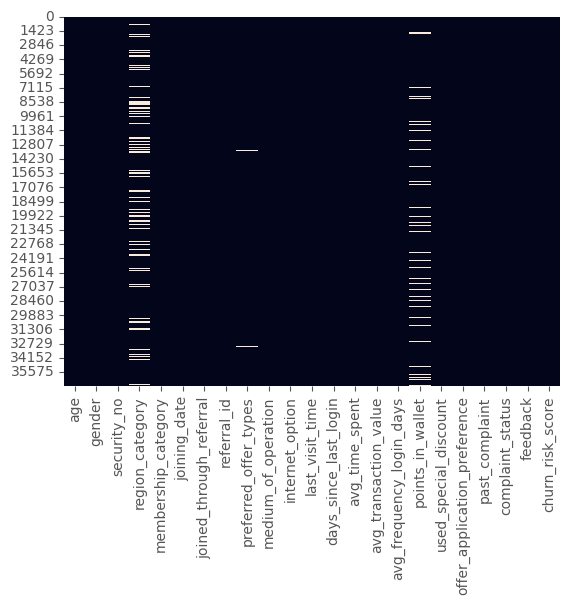

In [11]:
sns.heatmap(df.isna(), cbar = False)

**Initial Observations**<br>
- `region_category` and `points_in_wallets`has high number of null values
- `reffered_offer_types` has  less null values

- `age`: numeric col: suggests normal distribution
- `days_since_last_login`: scaler quantity: it contains -ive values
- `security_no`: identifier (must be dropped)

### 1.2.4 EDA

In [12]:
# Dropping Identifiers
df = df.drop(columns = 'security_no')
categorical_features = categorical_features.drop(columns = 'security_no')

#### 1.2.4.1 Univariate Analysis

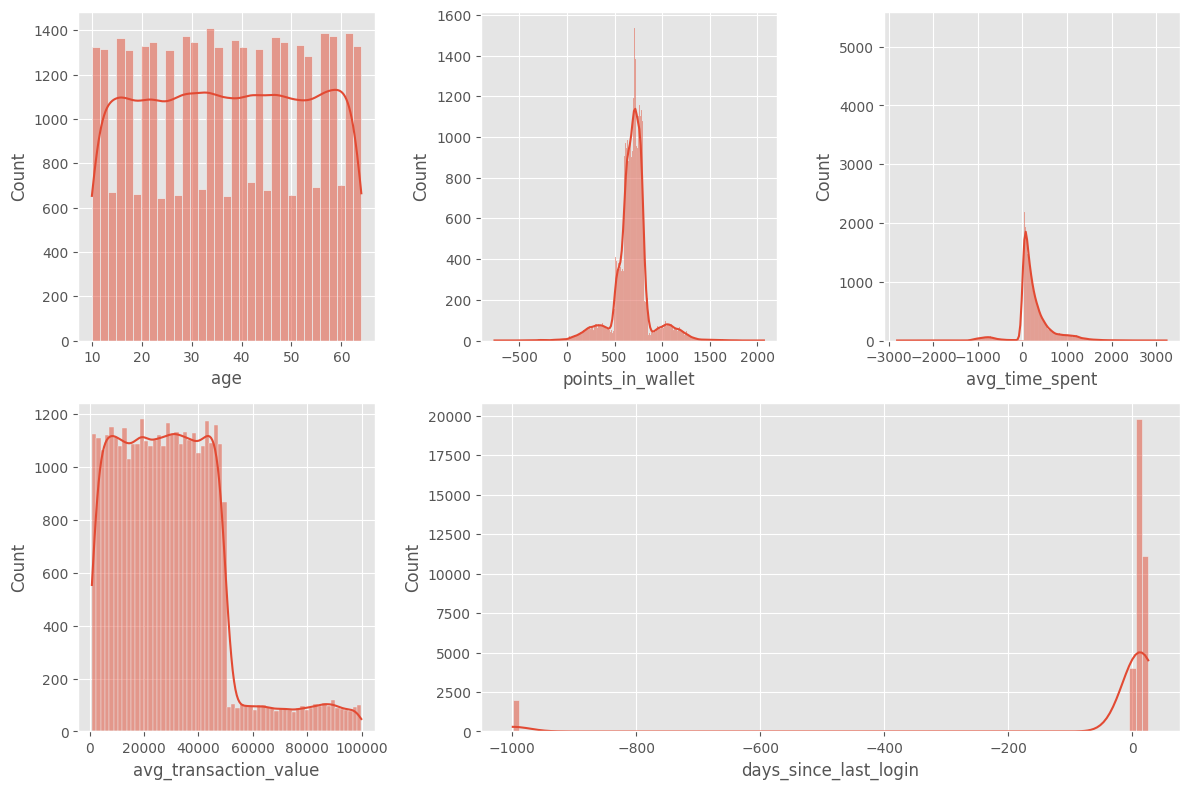

In [13]:
# Numeric Features
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(numeric_features['age'], kde = True, ax = ax1)

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(numeric_features['points_in_wallet'], kde = True, ax = ax2)

ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(numeric_features['avg_time_spent'], kde = True, ax = ax3)

ax4 = fig.add_subplot(gs[1, 0])
sns.histplot(numeric_features['avg_transaction_value'], kde = True, ax = ax4)

ax5 = fig.add_subplot(gs[1, 1:])
sns.histplot(numeric_features['days_since_last_login'], bins = 100, kde = True, ax = ax5)


fig.set_tight_layout('tight')
plt.show()

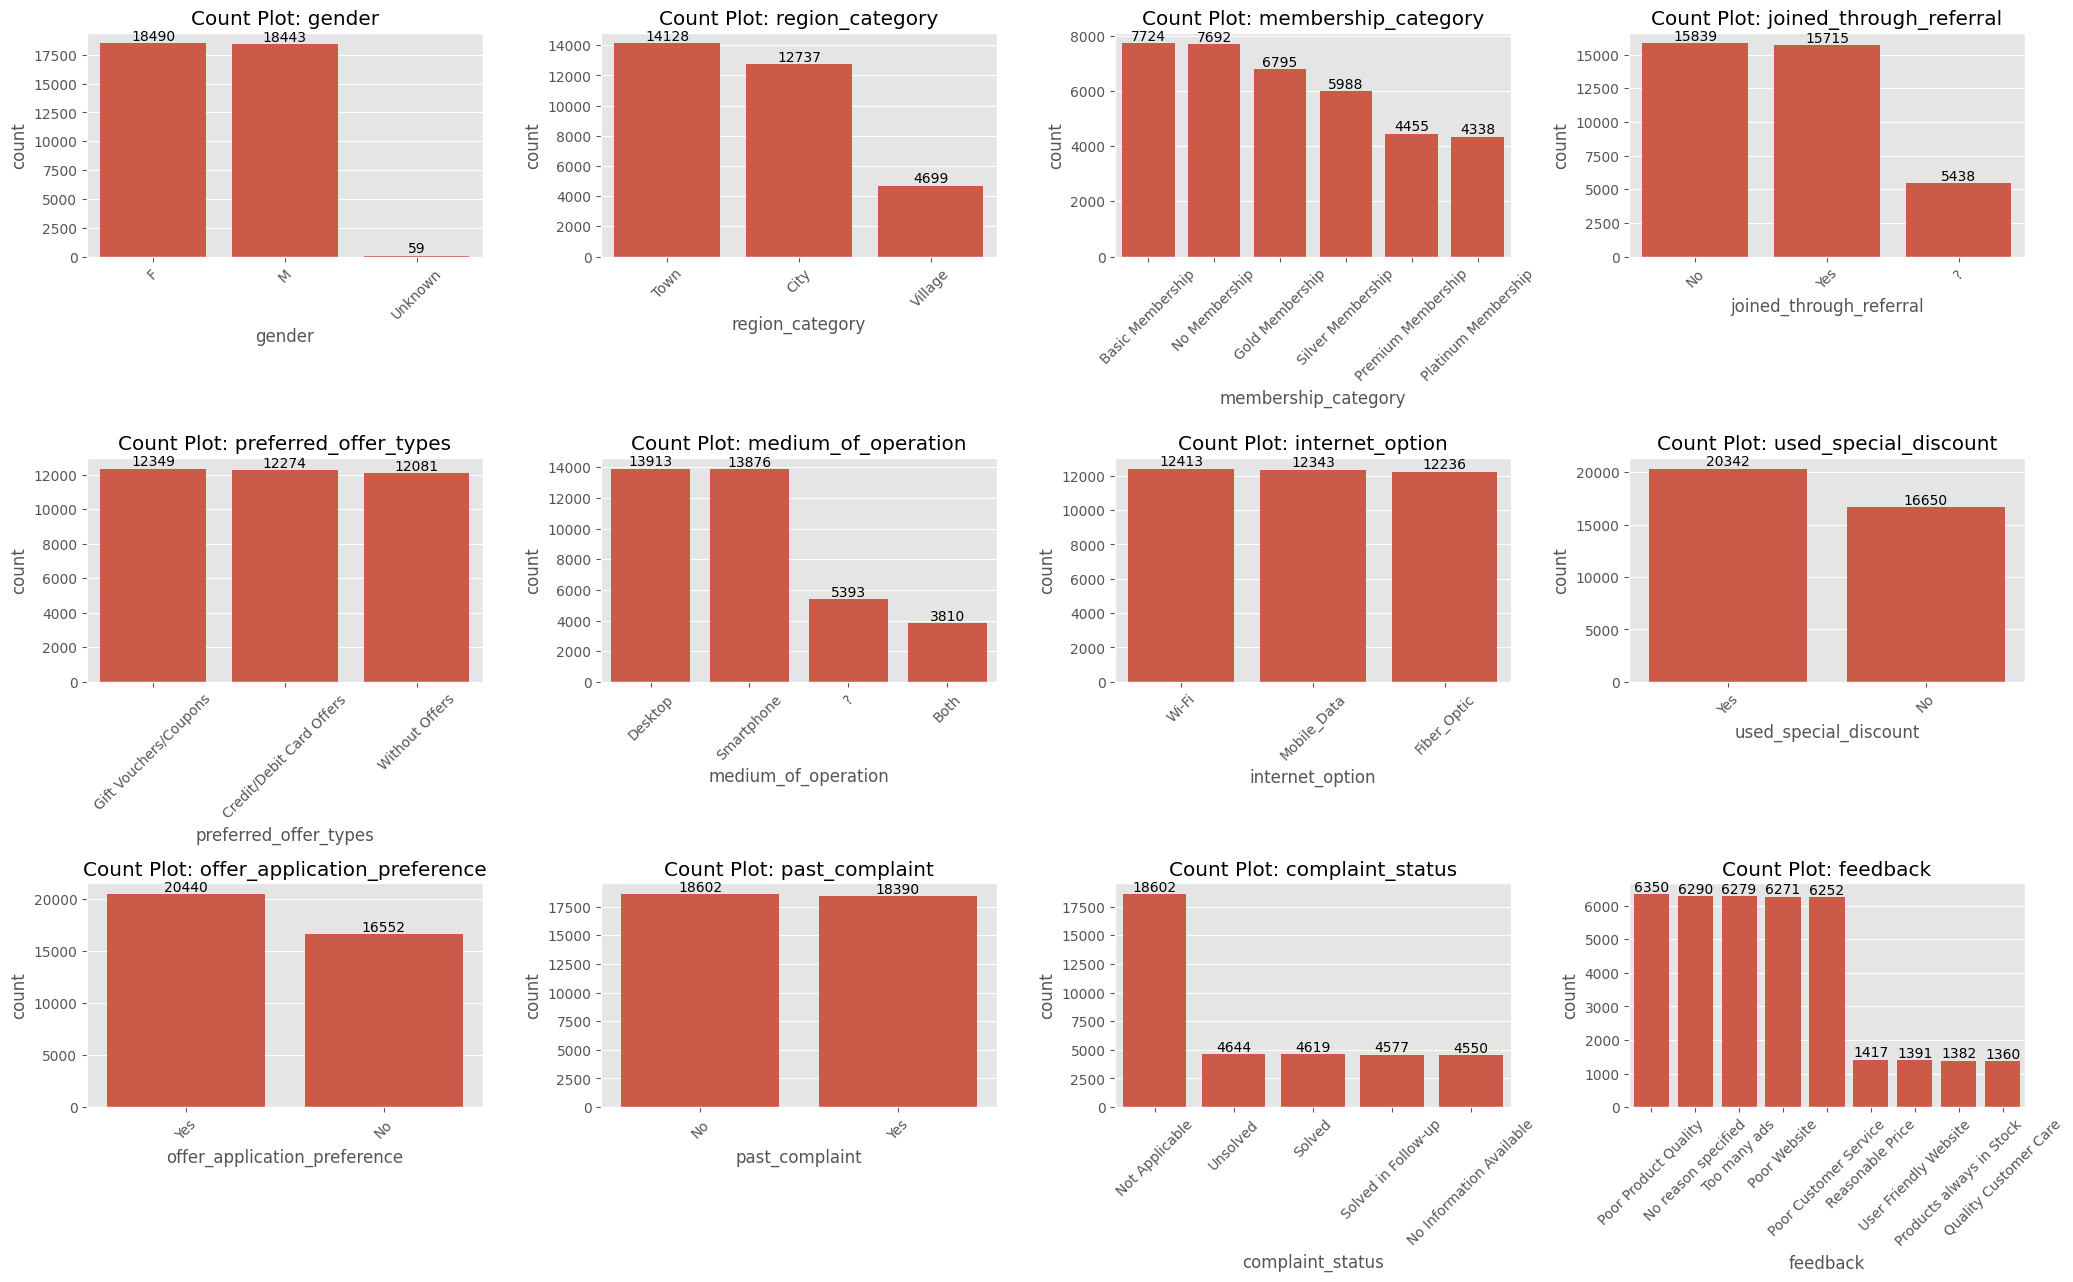

cols with high cardinality: ('joining_date', 'referral_id', 'last_visit_time', 'avg_frequency_login_days')


In [14]:
high_cardinality_cols = tuple()

fig = plt.figure(figsize=(25, 25))
gs = GridSpec(5, 4, figure=fig, wspace=0.3, hspace=0.9)

_ = []
plot_num = 0  # Track how many plots have been drawn

for col in categorical_features.columns:
    if df[col].nunique() <= 10:
        # Calculate current row and column for grid
        row_index = plot_num // 4
        col_index = plot_num % 4

        ax = fig.add_subplot(gs[row_index, col_index])
        _.append(ax)

        sns.countplot(
            x=categorical_features[col],
            ax=ax,
            order=categorical_features[col].value_counts().index
        )

        ax.bar_label(ax.containers[0])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title(f"Count Plot: {col}")

        plot_num += 1  # Only increment if we plotted

    else:
        high_cardinality_cols += (col, )

plt.tight_layout()
plt.show()

print(f"cols with high cardinality: {high_cardinality_cols}")

- **`gender`**: suggests it has invalid values: 'unknown'
- `region_category`: `Town` > `City` > `Village`
- `membership_category`: `Basic Membership` > `No Membership` > `Gold Membership` > `Silver Membership` > `Premium Membership` > `Platinium Membership`
- **`joined through referals`** contains missing values: '?'
- `preferred_offer_types`: Gift Voucher ~ Debit Card Offers ~ Without Offers
- **`medium of operation`** has missing values: ?
- `internet_option` Wifi ~ MobileData ~ Fiber Optic
- `used_special_discount` Yes > No
- `offer_application_preference` Yes > No
- `past complaint` Yes ~ No
- `complaint_status` Not Applicable > Unresolved ~ Solved ~ Solved in Follow-up ~ No Info Available
- `feedback` Poor Product Quality ~ No reason Specified ~ Too many ads ~ Poor Webssite ~ Poor Customer Service
- High Cardinality Cols: **`joining_date`**, **`referral_id`**, **`last_visit_time`**, **`avg_frequency_login_days`**

<Axes: xlabel='avg_frequency_login_days', ylabel='Count'>

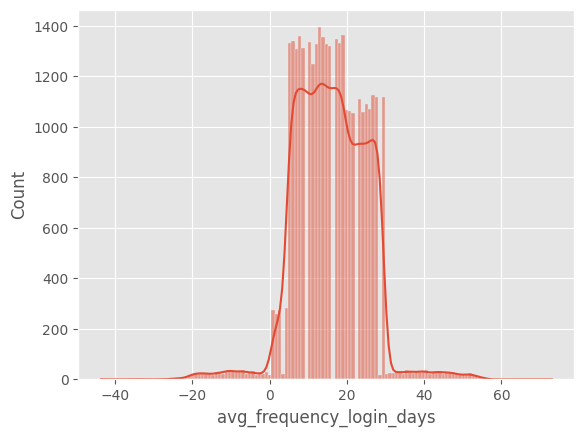

In [57]:
def check_numeric_val(val):
    '''This Function will return Numeric Value if string is numeric in nature else return np.nan'''
    try: 
        return float(val)
    except Exception as e:
        return np.nan
        
# Preprocessing last_visit_time
# Typecasting to int
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].map(check_numeric_val)

plt.title('Distribution: Avg. frequency')
sns.histplot(x = df['avg_frequency_login_days'], kde = True)

sns.barplot()

In [53]:
df['avg_frequency_login_days']

0           17
1           10
2           22
3            6
4           16
         ...  
36987        6
36988       28
36989    Error
36990       20
36991    Error
Name: avg_frequency_login_days, Length: 36992, dtype: object

nan